In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss, fast_sst, frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

torch.Size([1, 25000])


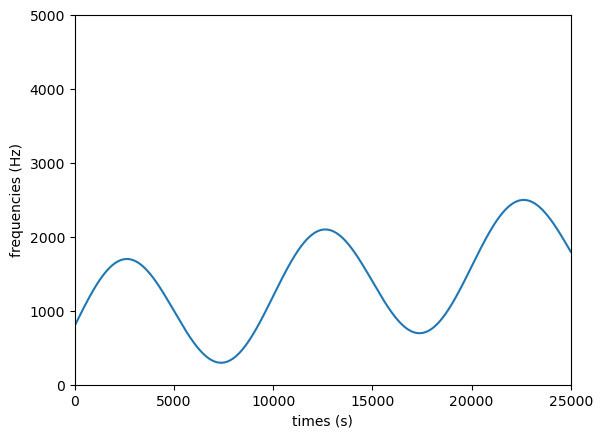

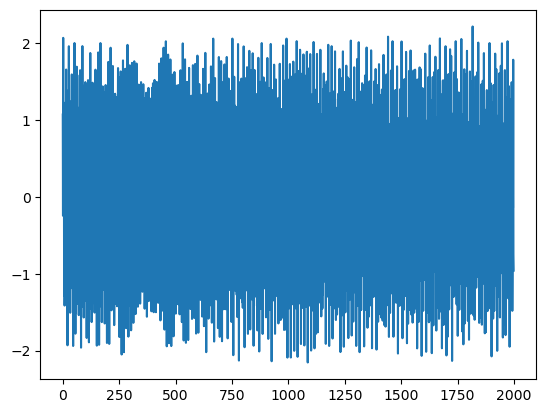

In [2]:
sr = 1e4; support = 1_000; stride = 100; epochs = 100_000; 
f_start = 125; f_end = 225; t_start = 75; t_end = 175
lr = 100; patience = 99; win_min = 100; threshold = 1;


t = torch.arange(0, 2.5, 1/sr)
f = (torch.sin(2*pi*t) + torch.ones_like(t) + .5 * t)
f = f/f.max()*0.5*sr/2

plt.plot(f)
plt.ylim(top=.5*sr, bottom=0)
plt.xlim(left=0, right=25_000)
plt.ylabel('frequencies (Hz)')
plt.xlabel('times (s)');


x = torch.sin(2*pi*torch.cumsum(f/sr, dim=0) ) 
x += torch.sin(2*pi*torch.cumsum(0.8/2* torch.ones_like(t), dim=0))
x += 0.1 *torch.randn(t.shape)

plt.figure()
plt.plot(x[:2_000])

x = x[None, ...].to(device)
#f = f.to(device)
print(x.shape)       

# specs = {} 
# stfts = {}
# wins = {}
# losses = {} 
# f_hats = {} 
# ss = {} 
# losses2 = {} 
# f_hats2 = {} 
# mse = {} 
# mse2 = {} 

# with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_f_hats2.pkl", "wb") as file: pickle.dump(f_hats2, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_mse.pkl", "wb") as file: pickle.dump(mse, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/1_mse2.pkl", "wb") as file: pickle.dump(mse2, file, pickle.HIGHEST_PROTOCOL)

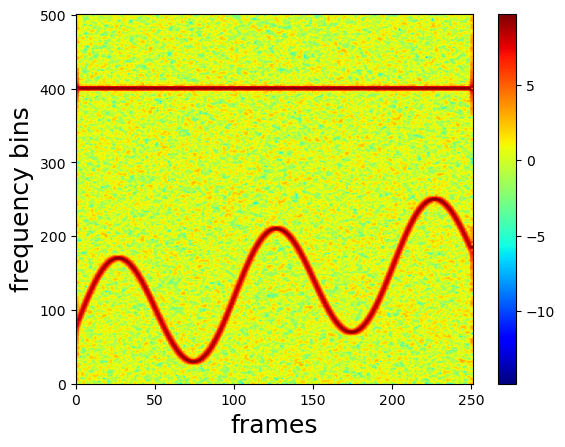

In [3]:
spec = torchaudio.transforms.Spectrogram(n_fft=support, win_length=500, hop_length=stride)(x.cpu())
ax = plt.subplot()
im = ax.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
plt.colorbar(im, ax=ax)
plt.ylabel('frequency bins', fontsize=18)
plt.xlabel('frames', fontsize=18);

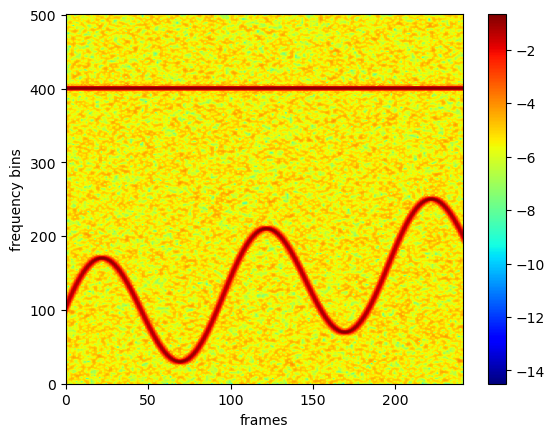

In [4]:
dstft = FDSTFT(x, win_length=500, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
#dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False) 

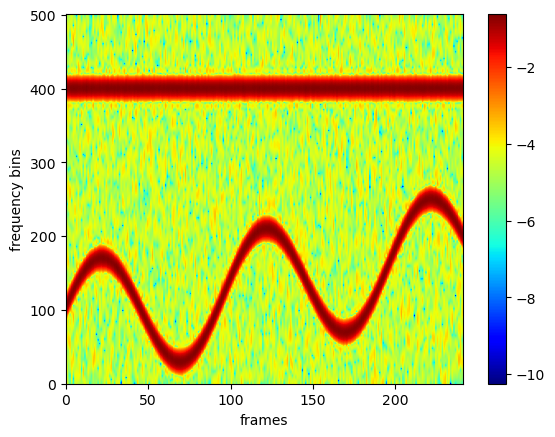

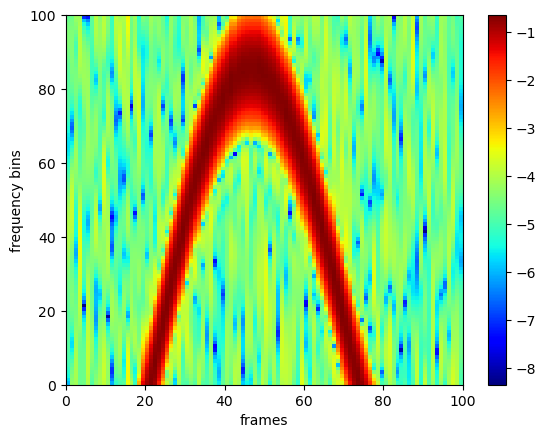

In [5]:
dstft = FDSTFT(x, win_length=100, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)


with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['100'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['100'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['100'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['100'] = entropy_loss(spec).cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

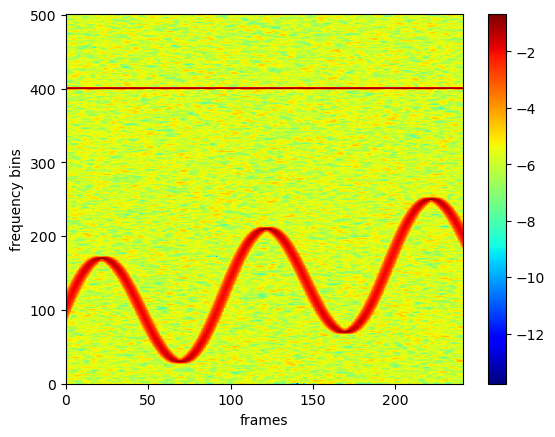

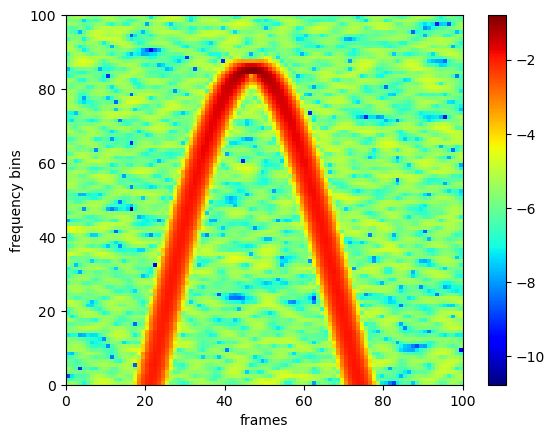

In [6]:
dstft = FDSTFT(x, win_length=1_000, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['1000'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['1000'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['1000'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['1000'] = entropy_loss(spec).cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Single window length

Epoch 00109: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00209: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00309: reducing learning rate of group 0 to 1.0000e-01.
308 495.9


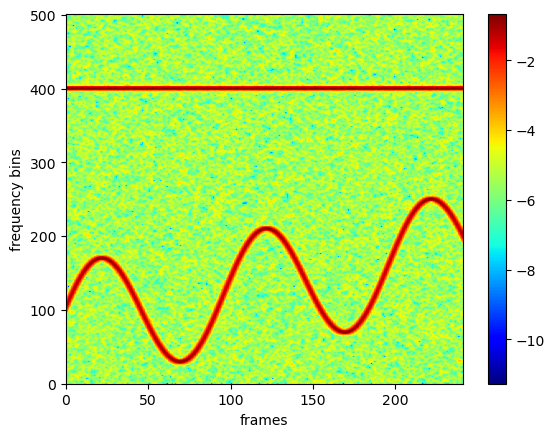

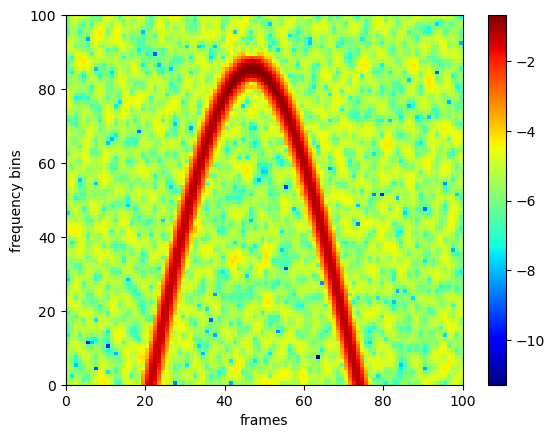

In [7]:
dstft = FDSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

min_err = 100
min_win = 0

for epoch in range(epochs):
    opt.zero_grad()    
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] <  threshold:
        break
    
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\theta$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\theta$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\theta$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\theta$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-varying window length

Epoch 00143: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00243: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00343: reducing learning rate of group 0 to 1.0000e-01.
342


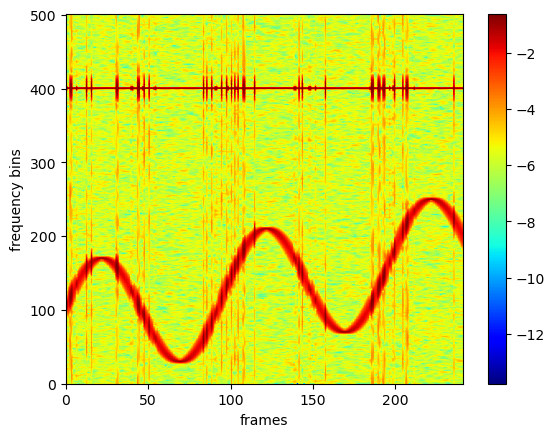

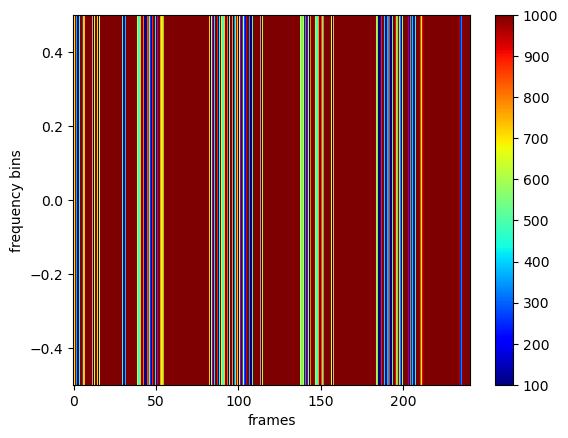

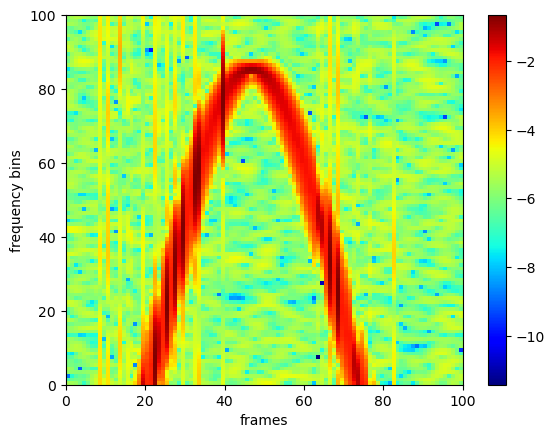

In [8]:
dstft = FDSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=win_min)
params = [{'params': dstft.win_length, 'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

for epoch in range(epochs):
    opt.zero_grad()    
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] <  threshold:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\theta_t$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\theta_t$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\theta_t$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\theta_t$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00101: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00201: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00301: reducing learning rate of group 0 to 1.0000e-01.
300


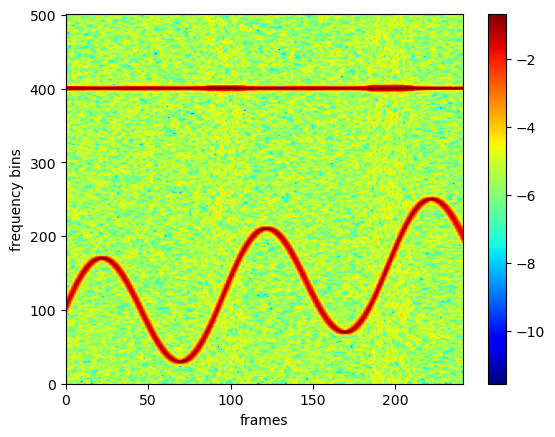

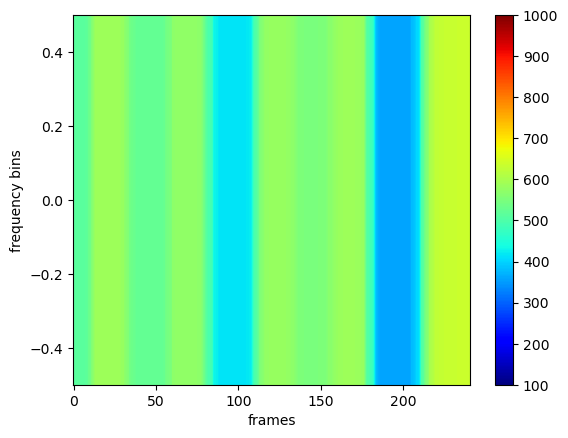

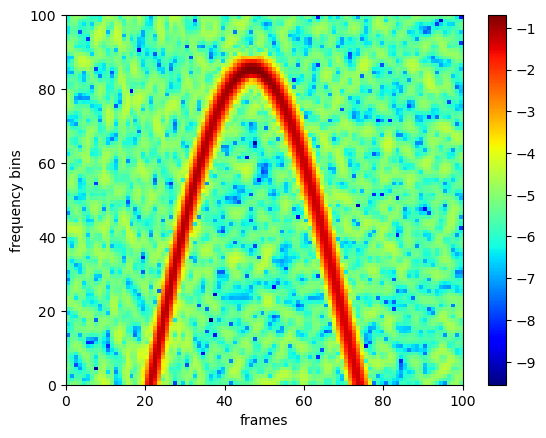

In [9]:
dstft = FDSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=win_min)
params = [{'params': dstft.win_length, 'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

for epoch in range(epochs):
    opt.zero_grad()    
    spec, stft = dstft(x)
    err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] <  threshold:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\tilde{\\theta}_t$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\tilde{\\theta}_t$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\tilde{\\theta}_t$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\tilde{\\theta}_t$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)



Frequency-varying window length

Epoch 00137: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00240: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00340: reducing learning rate of group 0 to 1.0000e-01.
339


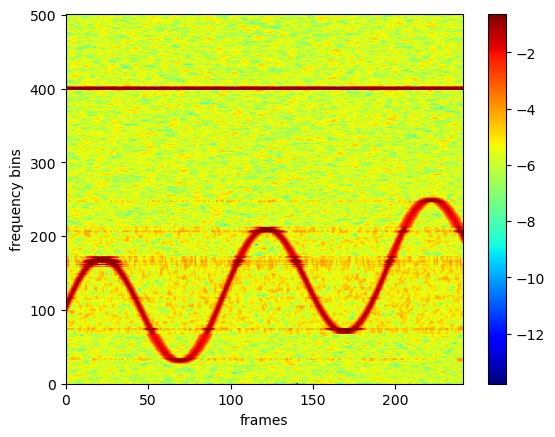

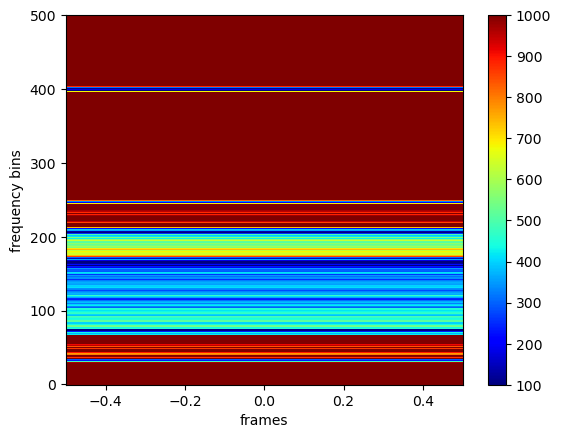

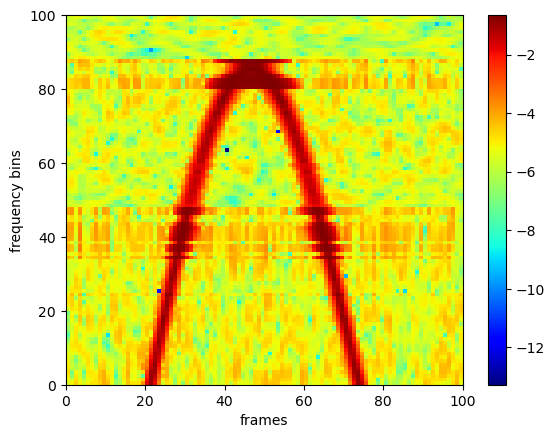

In [11]:
dstft = DSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=win_min)
params = [{'params': dstft.win_length,    'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] <  threshold:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\theta_f$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\theta_f$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\theta_f$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\theta_f$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00101: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00386: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00730: reducing learning rate of group 0 to 1.0000e-01.
729


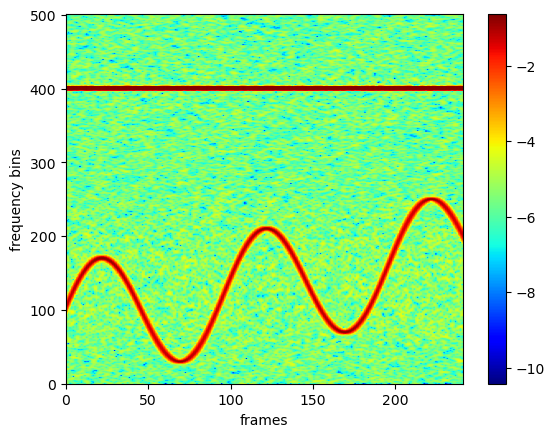

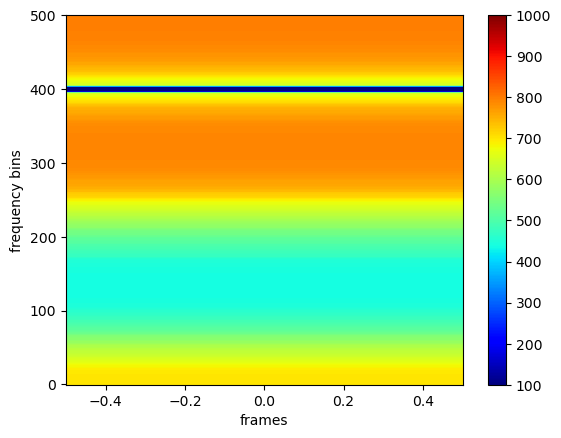

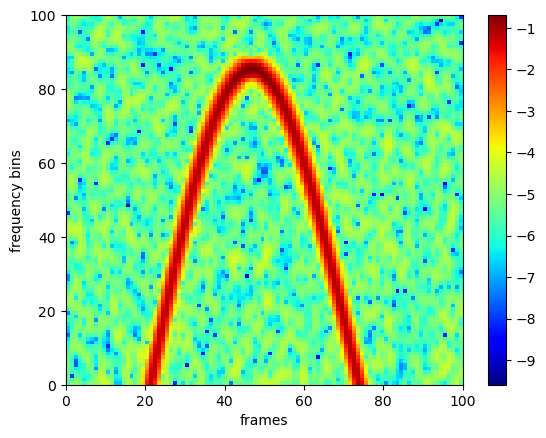

In [ ]:
dstft = DSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=win_min)
params = [{'params': dstft.win_length, 'lr': lr},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec) + 0.04 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] <  threshold:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\tilde{\\theta}_f$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\tilde{\\theta}_f$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\tilde{\\theta}_f$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\tilde{\\theta}_f$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-and-frequency-varying window length

Epoch 00208: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00318: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00418: reducing learning rate of group 0 to 1.0000e-01.
417


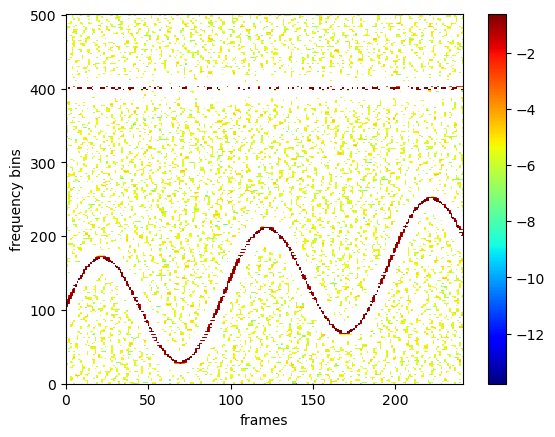

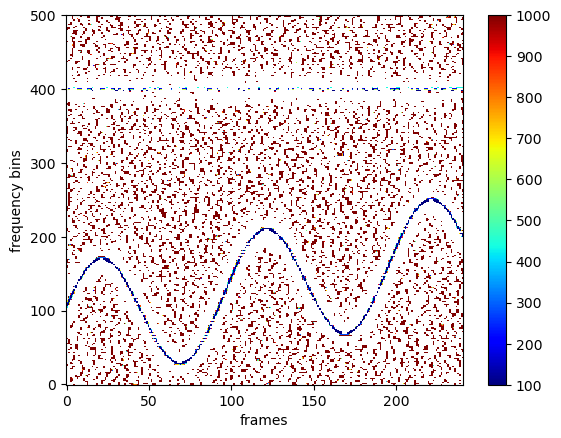

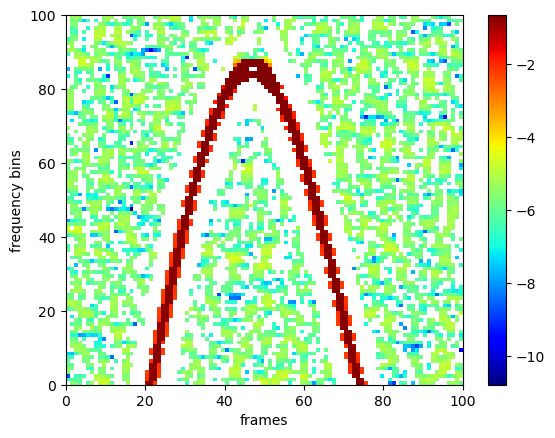

In [ ]:
dstft = DSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=win_min)
params = [{'params': dstft.win_length, 'lr': lr},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] <  threshold:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\theta_{tf}$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\theta_{tf}$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\theta_{tf}$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\theta_{tf}$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)



Epoch 01112: reducing learning rate of group 0 to 1.0000e+01.
Epoch 01264: reducing learning rate of group 0 to 1.0000e+00.
Epoch 01385: reducing learning rate of group 0 to 1.0000e-01.
1384


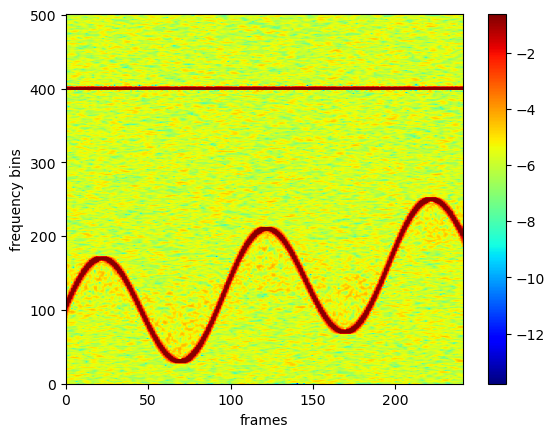

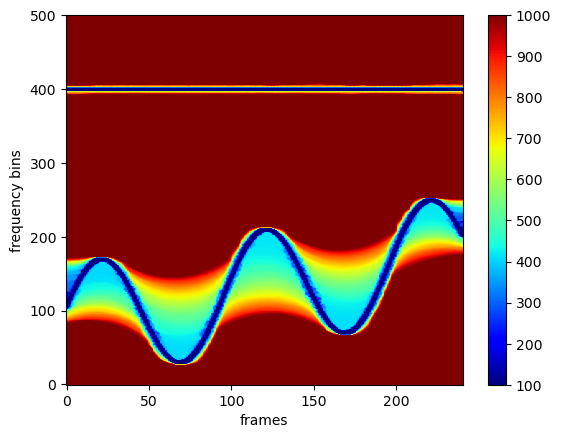

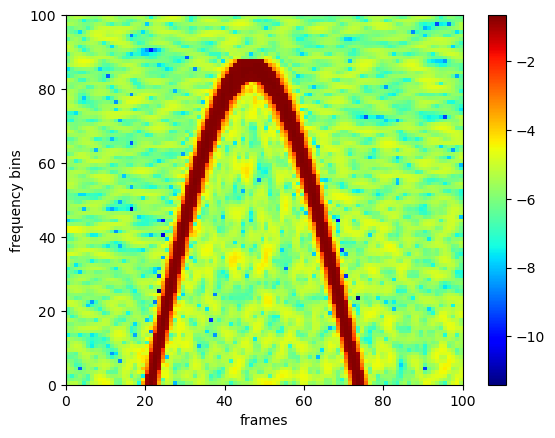

In [ ]:
dstft = DSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=win_min)
params = [{'params': dstft.win_length,'lr': lr}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec) + 0.02 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] <  threshold:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, f_start:f_end, t_start:t_end], x, bar=True, wins=False, weights=False)

with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['$\\tilde{\\theta}_{tf}$'] = spec.detach().cpu()
with open("../tmp/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['$\\tilde{\\theta}_{tf}$'] = stft.detach().cpu()
with open("../tmp/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['$\\tilde{\\theta}_{tf}$'] = dstft.actual_win_length.mean().detach().cpu(), dstft.actual_win_length.var().pow(.5).detach().cpu()
with open("../tmp/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['$\\tilde{\\theta}_{tf}$'] = entropy_loss(spec).detach().cpu().item()
with open("../tmp/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)



Synchrosqueezing

In [ ]:
with open("../tmp/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
with open("../tmp/1_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../tmp/1_losses2.pkl", "rb") as file: losses2 = pickle.load(file)

for key, stft in stfts.items():
    z = fast_sst(stft[0], 10, stft.shape[-2], stft.shape[-1], .25, device)
    ss[key] = z
    losses2[key] = entropy_loss(z).detach().cpu().item()
    
with open("../tmp/1_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
with open("../tmp/1_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)

/home/maxime/Documents/Projects/MyProjects/dstft/dstft/synchrosqueeze.py:21: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/Copy.cpp:276.)
  Z_Ts[eta, b] = Z_Ts[eta, b] + torch.mean(X[k, b])


Loss

496


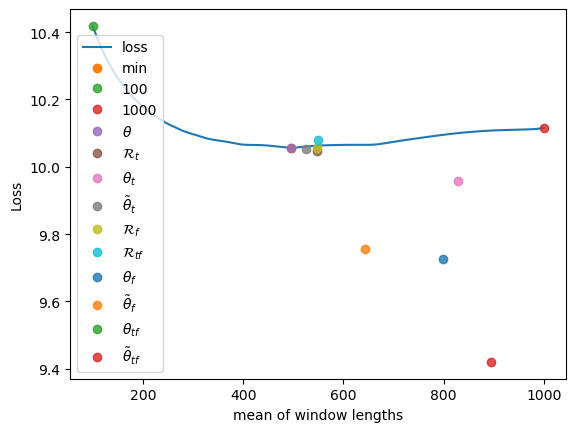

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, 1000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, 1000, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items():
    #print(wins[key], loss)
    plt.plot(wins[key][0], loss, 'o', alpha=.8, label=key)
plt.xlabel('mean of window lengths')
plt.ylabel('Loss')
plt.legend()
plt.show()

496


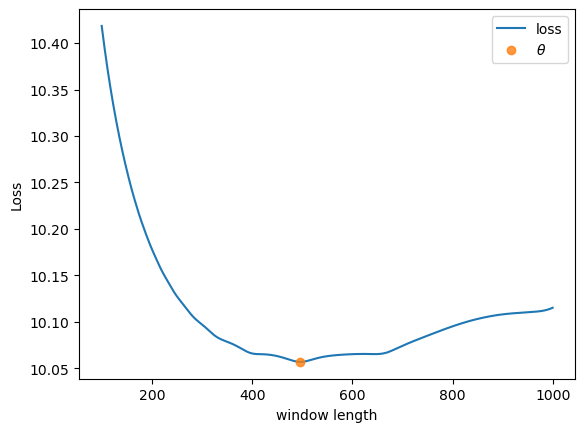

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, 1000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, 1000, 1), loss_function, label='loss')

with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
plt.plot(wins['$\\theta$'][0], losses['$\\theta$'], 'o', alpha=.8, label='$\\theta$')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

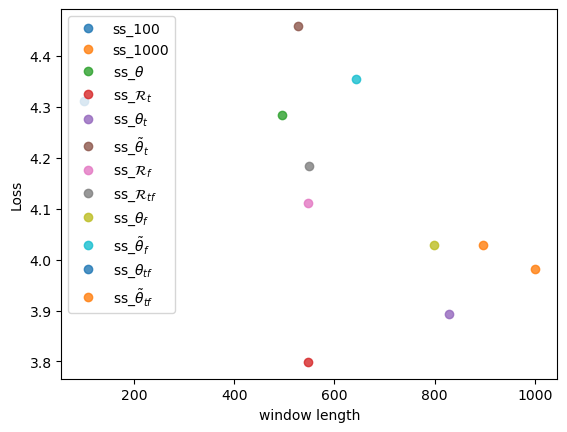

In [ ]:
with open("../tmp/1_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses2.items(): plt.plot(wins[key][0], loss, 'o', alpha=.8, label=f'ss_{key}')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

496


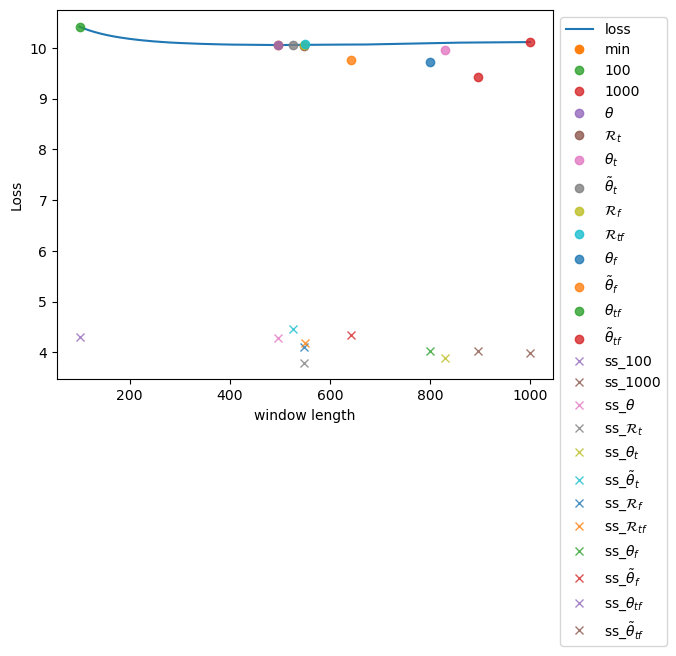

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, 1000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, 1000, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../tmp/1_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items(): plt.plot(wins[key][0], loss, 'o', alpha=.8, label=key)
for key, loss in losses2.items(): plt.plot(wins[key][0], loss, 'x', alpha=.8, label=f'ss_{key}')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('window length')
plt.ylabel('Loss')
plt.show()

['100', '1000', '$\\theta$', '$\\mathcal{R}_t$', '$\\theta_t$', '$\\tilde{\\theta}_t$', '$\\mathcal{R}_f$', '$\\mathcal{R}_{tf}$', '$\\theta_f$', '$\\tilde{\\theta}_f$', '$\\theta_{tf}$', '$\\tilde{\\theta}_{tf}$']
[10.418497085571289, 10.115257263183594, 10.056734085083008, 10.047393798828125, 9.95925521850586, 10.051992416381836, 10.056076049804688, 10.078387260437012, 9.725044250488281, 9.75505256652832, nan, 9.420377731323242]


(9.0, 10.939421939849854)

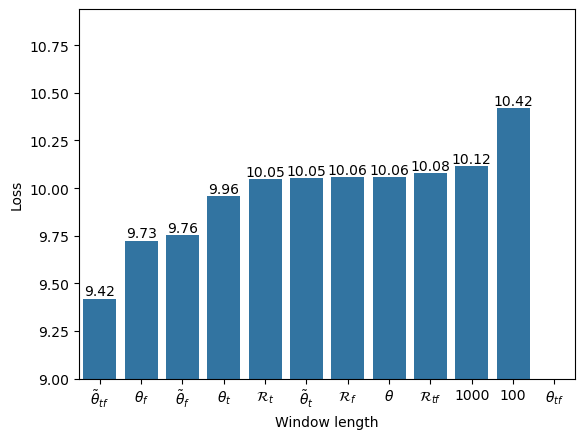

In [ ]:
keys = ['$\\theta$', 'random', 't2']
with open("../tmp/1_losses.pkl", "rb") as file: losses = pickle.load(file)
keys = list(losses.keys())
values = list(losses.values())
print(keys)
print(values)
df = pd.DataFrame({"Window length":keys, "Loss":values})

df.sort_values(by="Loss", axis=0, inplace=True)
df.head()
ax = sns.barplot(y='Loss', data=df, x="Window length")
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f'); 
ax.set_ylim(9)

Plot

100 torch.Size([501, 241])


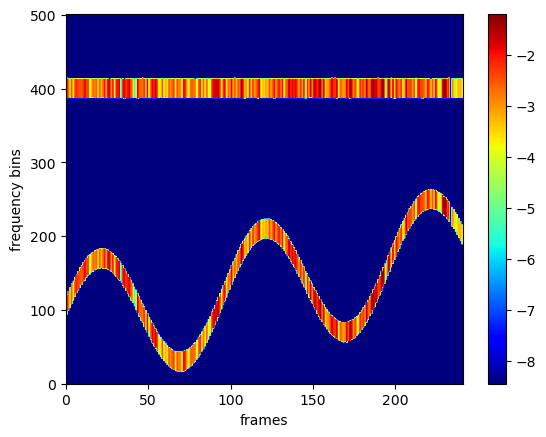

1000 torch.Size([501, 241])


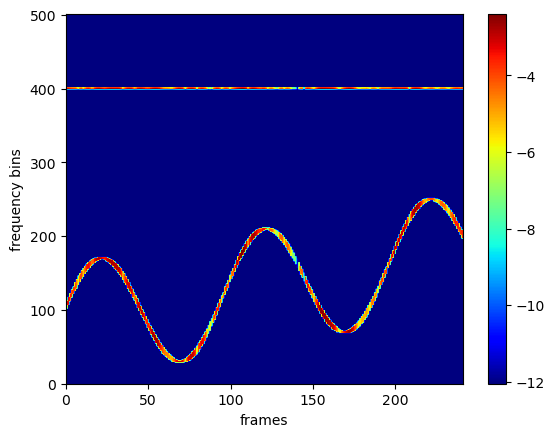

$\theta$ torch.Size([501, 241])


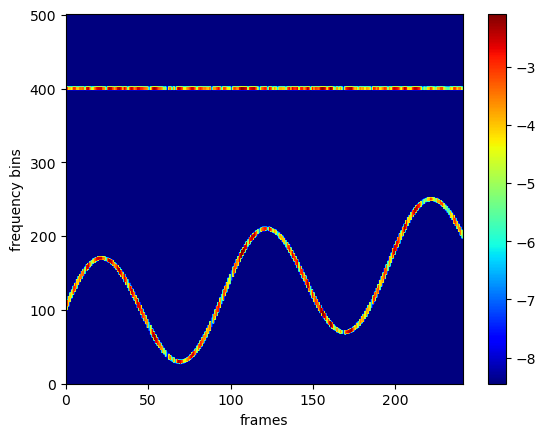

$\mathcal{R}_t$ torch.Size([501, 241])


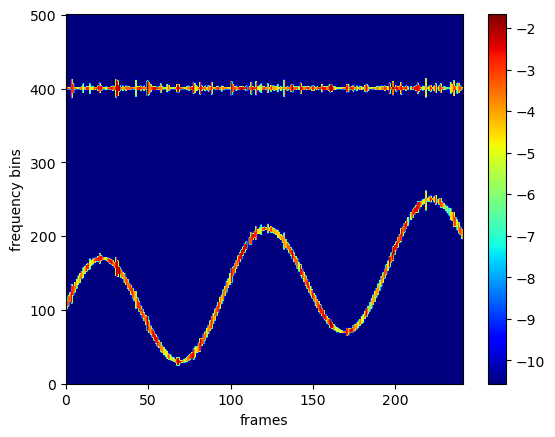

$\theta_t$ torch.Size([501, 241])


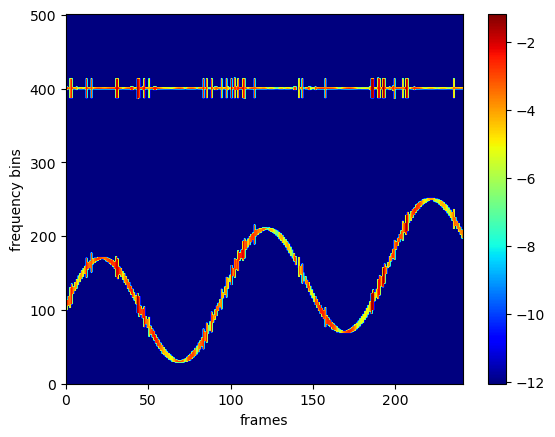

$\tilde{\theta}_t$ torch.Size([501, 241])


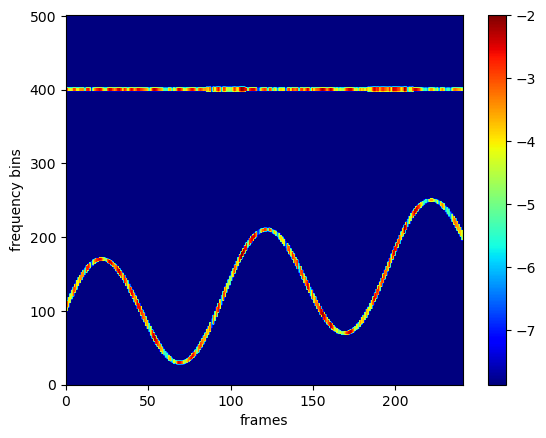

$\mathcal{R}_f$ torch.Size([501, 241])


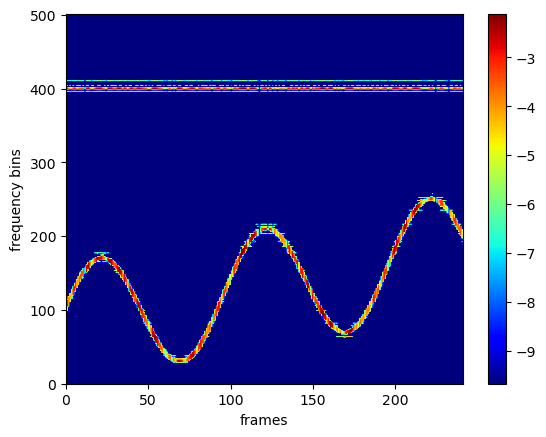

$\mathcal{R}_{tf}$ torch.Size([501, 241])


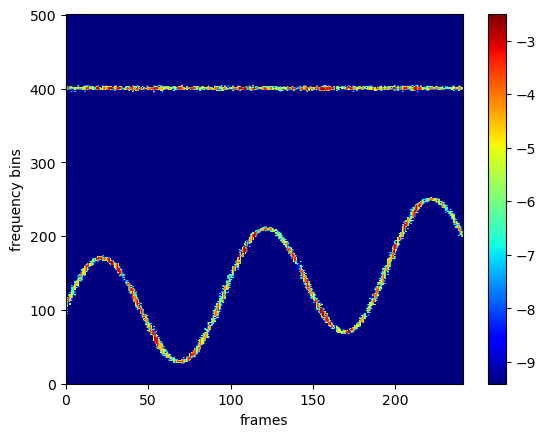

$\theta_f$ torch.Size([501, 241])


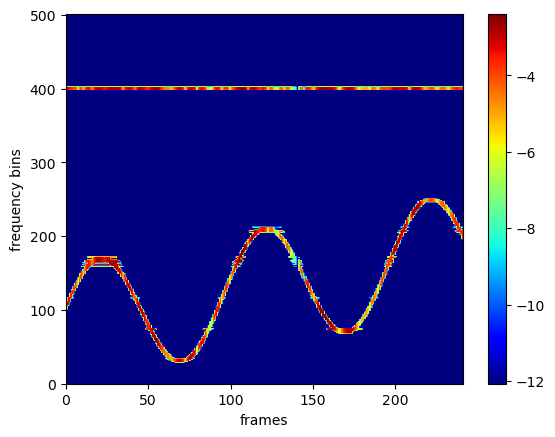

$\tilde{\theta}_f$ torch.Size([501, 241])


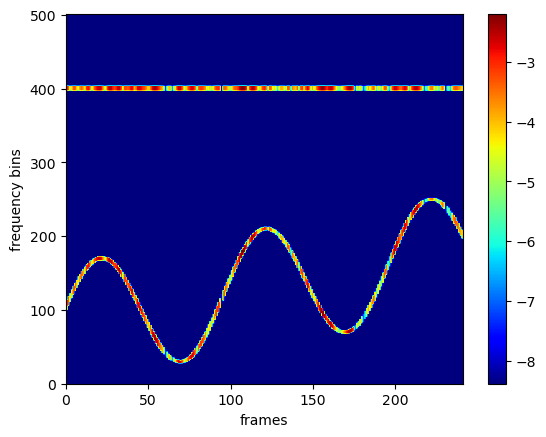

$\theta_{tf}$ torch.Size([501, 241])


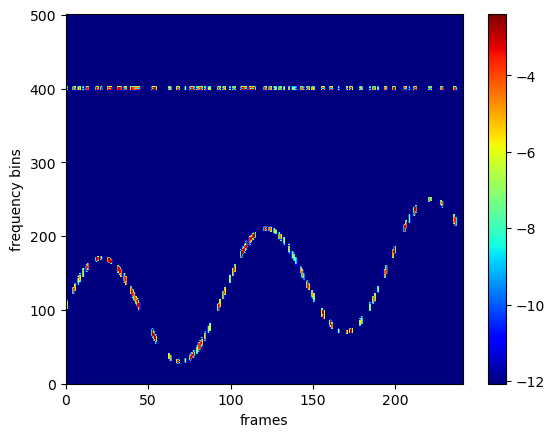

$\tilde{\theta}_{tf}$ torch.Size([501, 241])


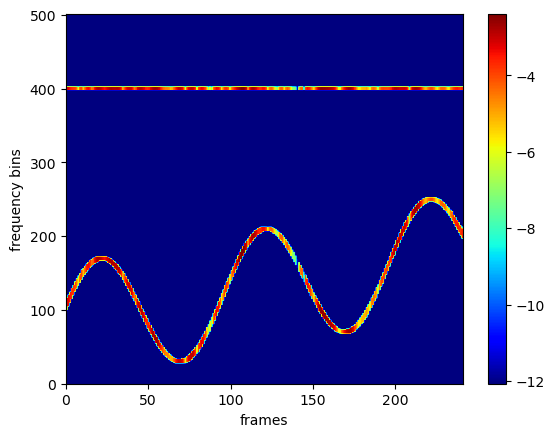

In [ ]:
with open("../tmp/1_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key, z.shape); dstft.print(z[None, ...], x, bar=True, wins=False, weights=False)

100


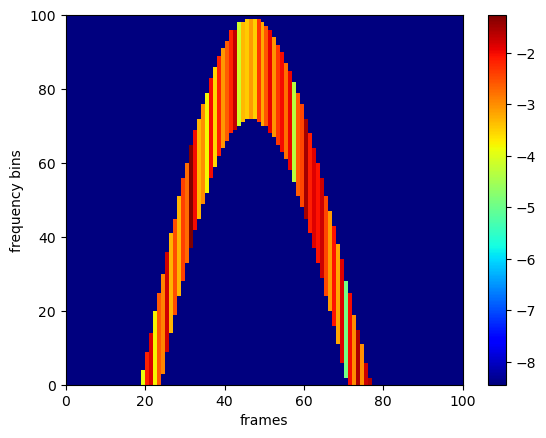

1000


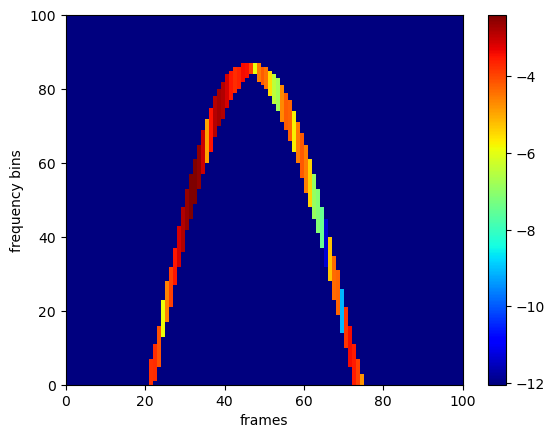

$\theta$


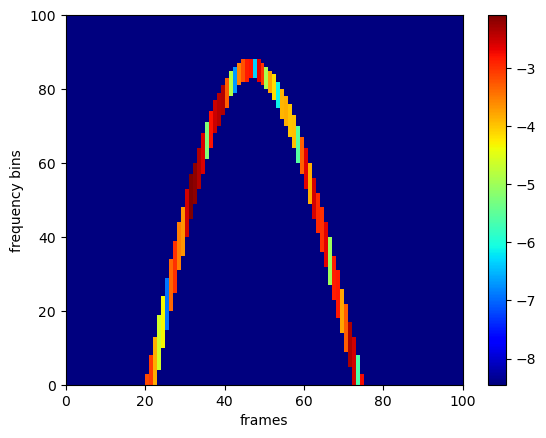

$\mathcal{R}_t$


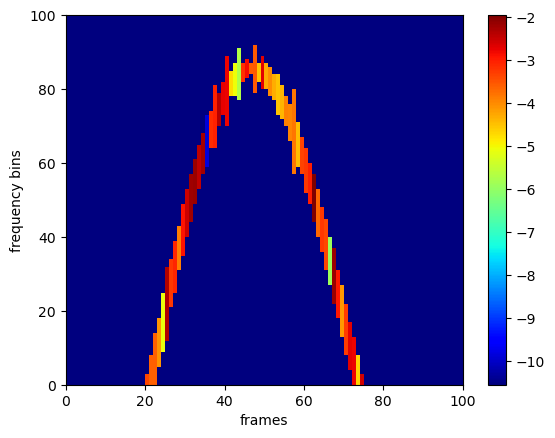

$\theta_t$


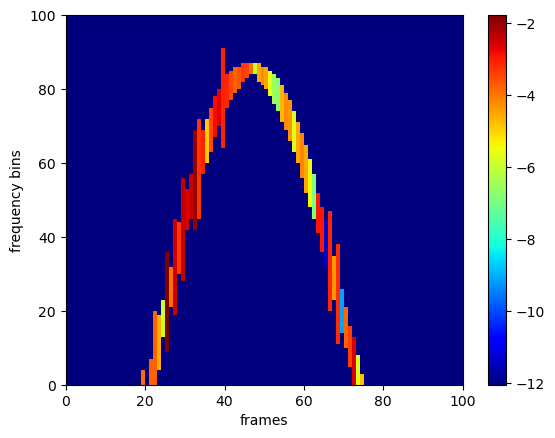

$\tilde{\theta}_t$


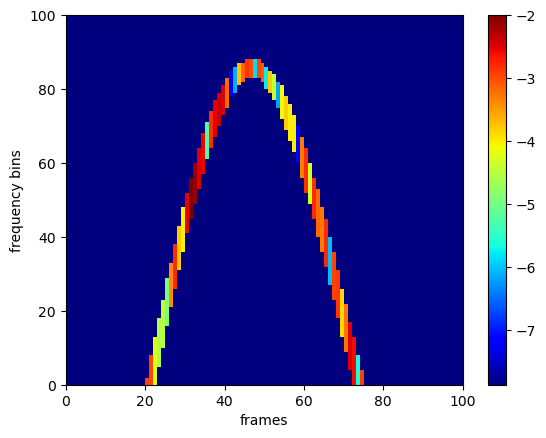

$\mathcal{R}_f$


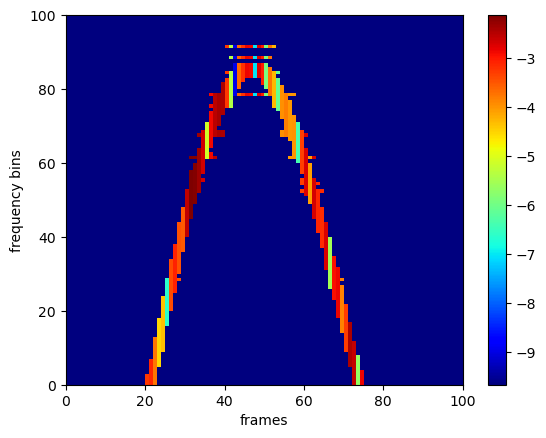

$\mathcal{R}_{tf}$


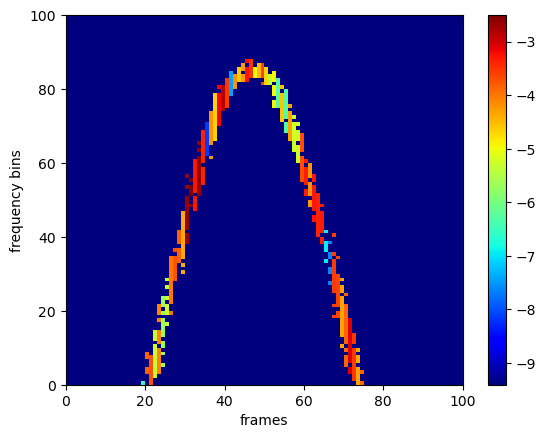

$\theta_f$


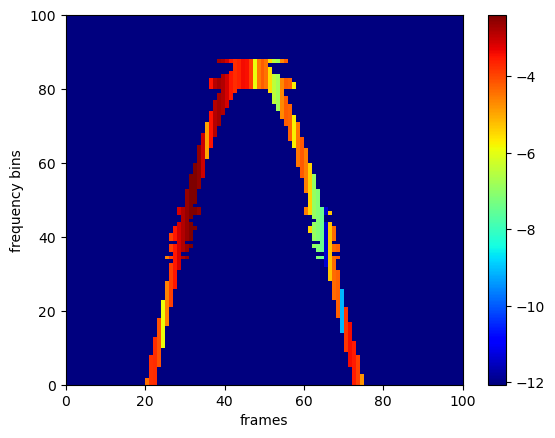

$\tilde{\theta}_f$


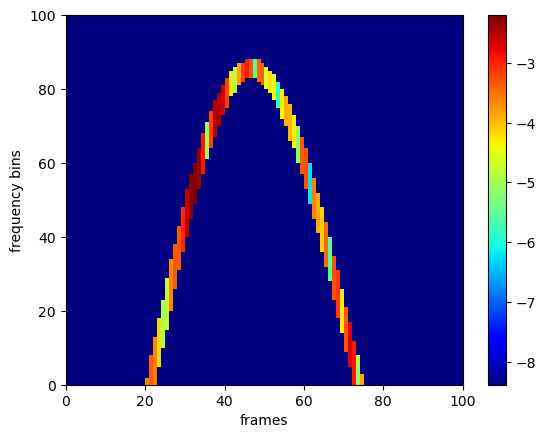

$\theta_{tf}$


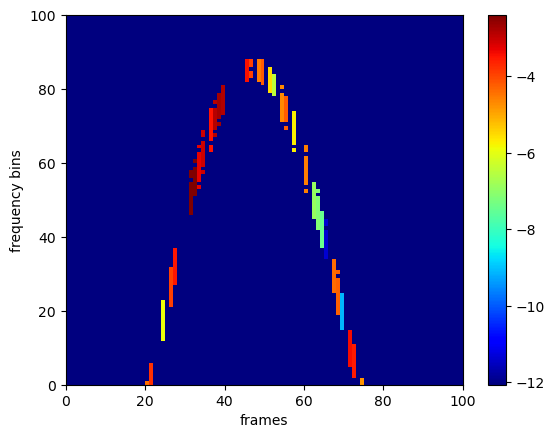

$\tilde{\theta}_{tf}$


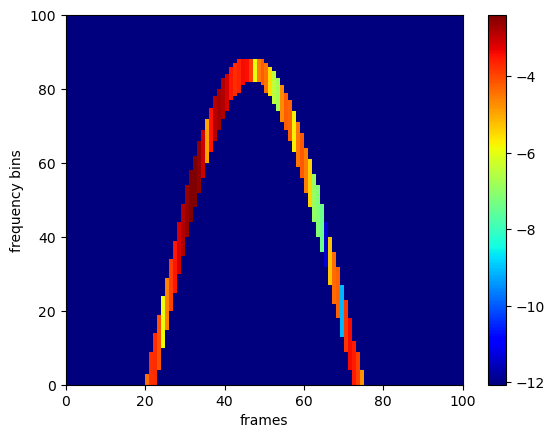

In [ ]:
with open("../tmp/1_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, 125:225, 75:175], x, bar=True, wins=False, weights=False)

$\hat{f}$

In [ ]:
with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
with open("../tmp/1_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
for key, spec in specs.items():
    print(key)
    f_hat, out = frequency_tracking(y=x, fs=sr, spec=spec[0].to(device), fmin=0, fmax=.3*sr, alpha=1e10, orders=[])
    f_hats[key] = out.cpu()
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]
    #plt.figure()
    #plt.title('Spectrogram')
    #ax = plt.subplot()
    #im = ax.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    #plt.ylabel('frequencies')
    #plt.xlabel('frames')
    #plt.colorbar(im, ax=ax)
    #plt.plot(out.detach().cpu(), '--r', linewidth=1)
    #plt.show()
with open("../tmp/1_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

100
1000
$\theta$
$\mathcal{R}_t$
$\theta_t$
$\tilde{\theta}_t$
$\mathcal{R}_f$
$\mathcal{R}_{tf}$
$\theta_f$
$\tilde{\theta}_f$
$\theta_{tf}$
$\tilde{\theta}_{tf}$


In [ ]:
with open("../tmp/1_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../tmp/1_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)
for key, z in ss.items():
    print(key)
    f_hat, out = frequency_tracking(y=x, fs=sr, spec=z.to(device), fmin=0, fmax=.3*sr, alpha=1e10, orders=[])
    f_hats[key] = out.cpu()
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]
    #plt.figure()
    #plt.title('SS')
    #ax = plt.subplot()
    #im = ax.imshow(z.detach().cpu().log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    #plt.ylabel('frequencies')
    #plt.xlabel('frames')
    #plt.colorbar(im, ax=ax)
    #plt.plot(out.detach().cpu(), '--r', linewidth=1)
    #plt.show()
with open("../tmp/1_f_hats2.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

100
1000
$\theta$
$\mathcal{R}_t$
$\theta_t$
$\tilde{\theta}_t$
$\mathcal{R}_f$
$\mathcal{R}_{tf}$
$\theta_f$
$\tilde{\theta}_f$
$\theta_{tf}$
$\tilde{\theta}_{tf}$


100


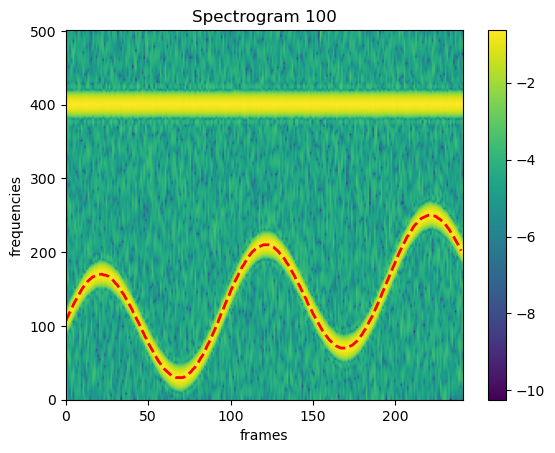

1000


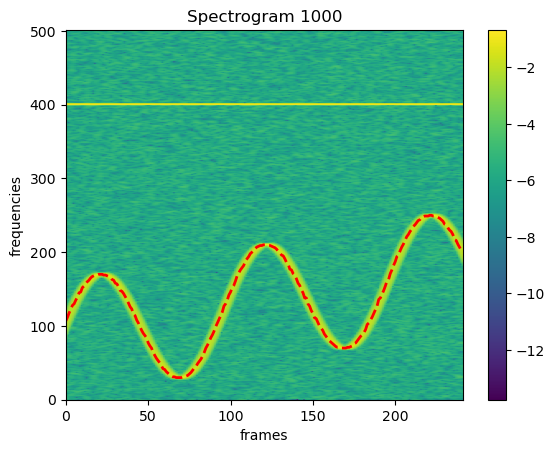

$\theta$


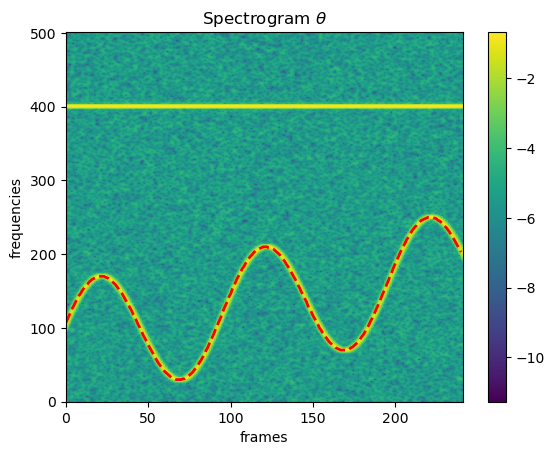

$\mathcal{R}_t$


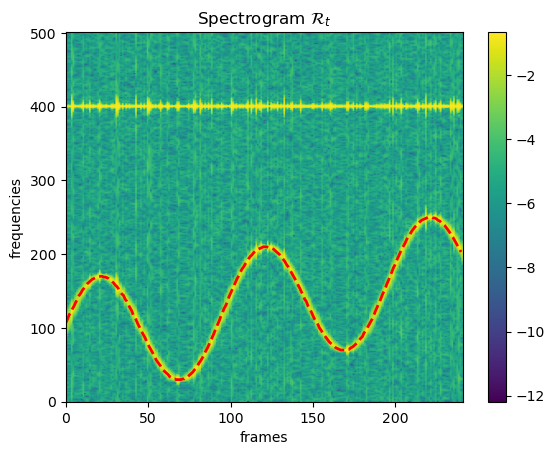

$\theta_t$


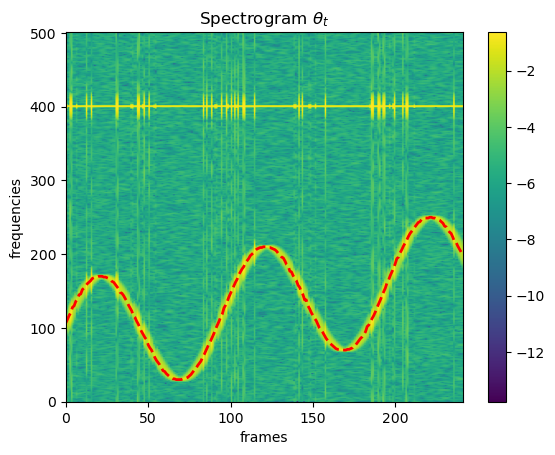

$\tilde{\theta}_t$


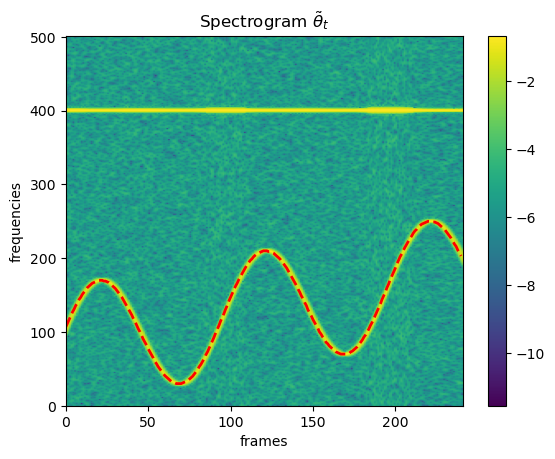

$\mathcal{R}_f$


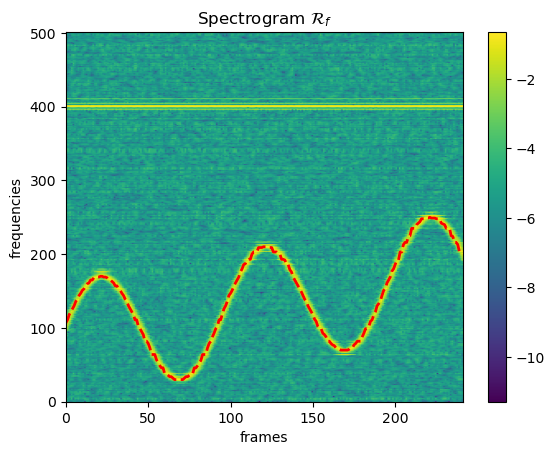

$\mathcal{R}_{tf}$


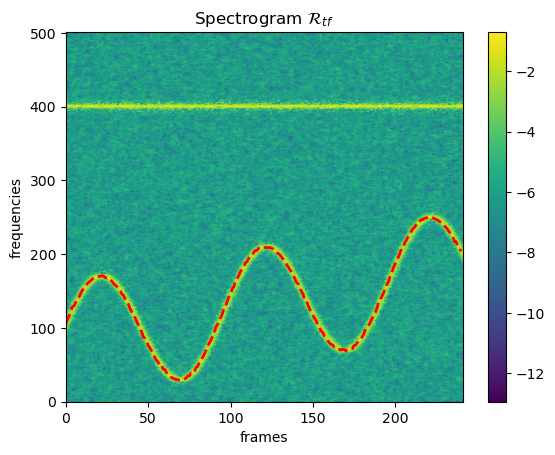

$\theta_f$


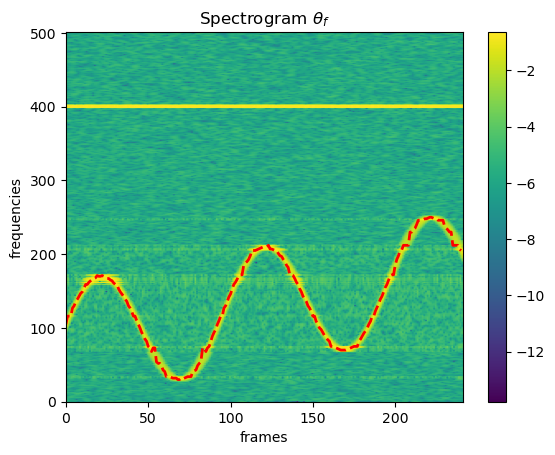

$\tilde{\theta}_f$


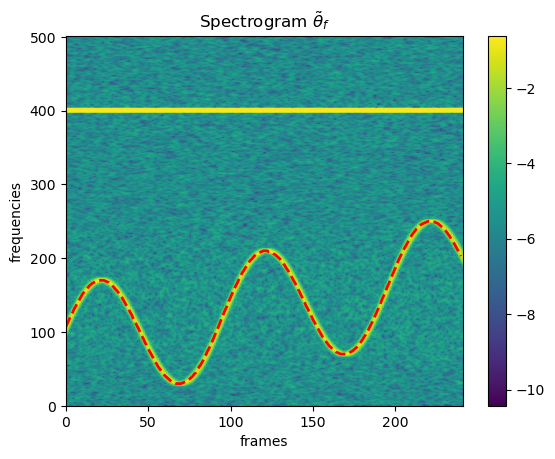

$\theta_{tf}$


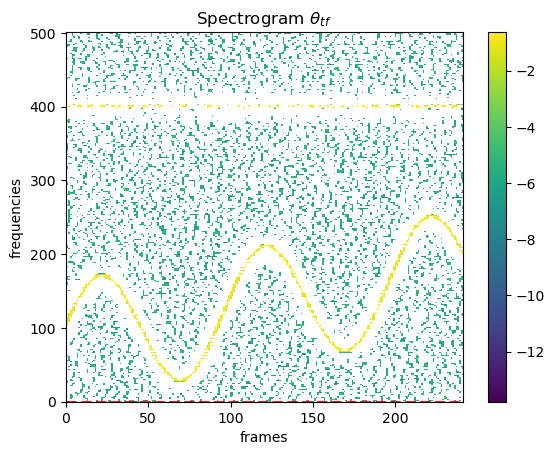

$\tilde{\theta}_{tf}$


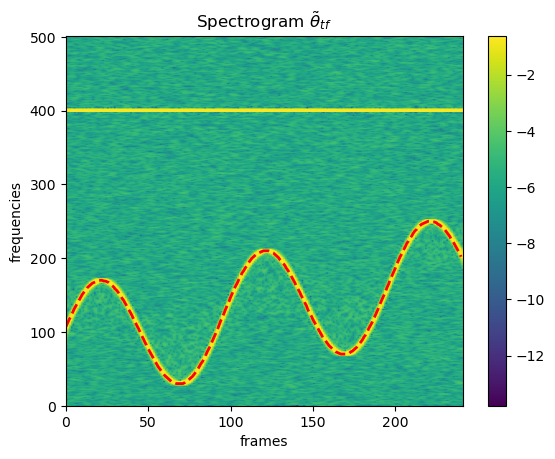

In [ ]:
with open("../tmp/1_specs.pkl", "rb") as file: specs = pickle.load(file)
with open("../tmp/1_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)

for key, out in f_hats.items(): 
    print(key)    
    plt.figure()
    plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(specs[key][0].log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu(),  'r--', linewidth=2)
    plt.show()

100


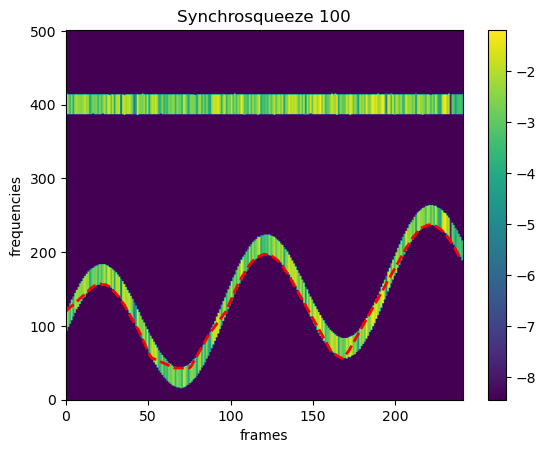

1000


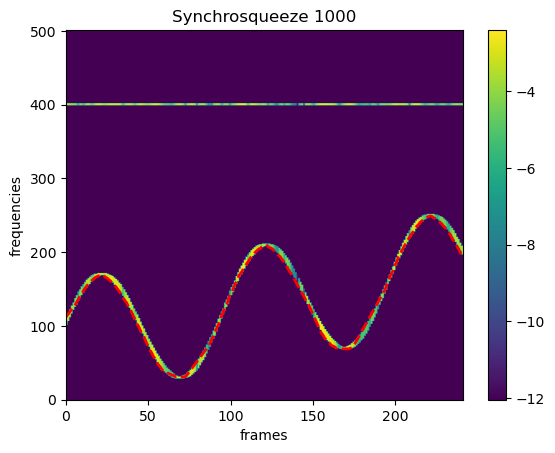

$\theta$


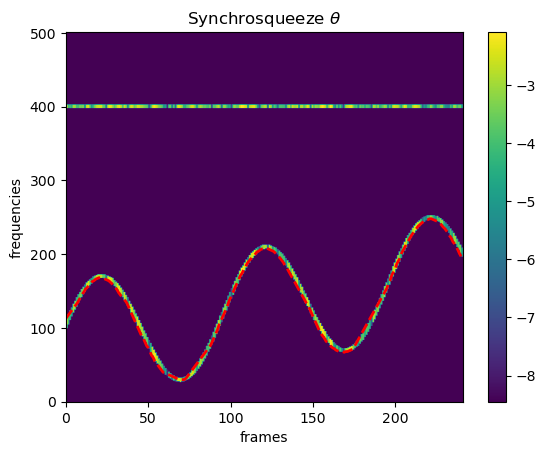

$\mathcal{R}_t$


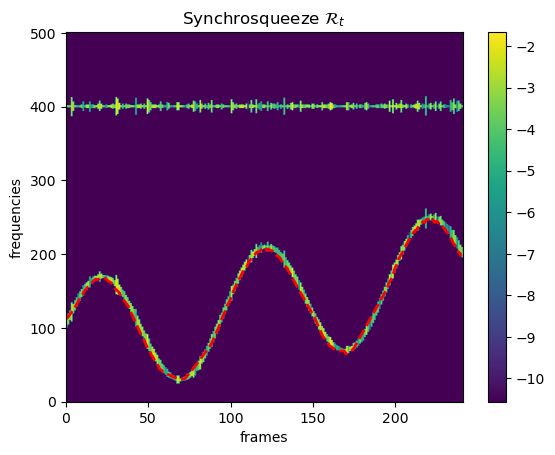

$\theta_t$


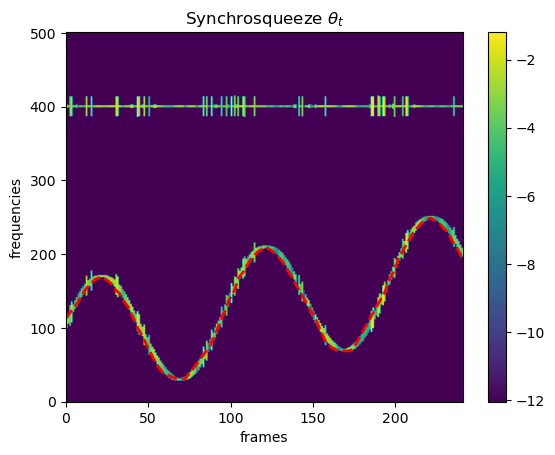

$\tilde{\theta}_t$


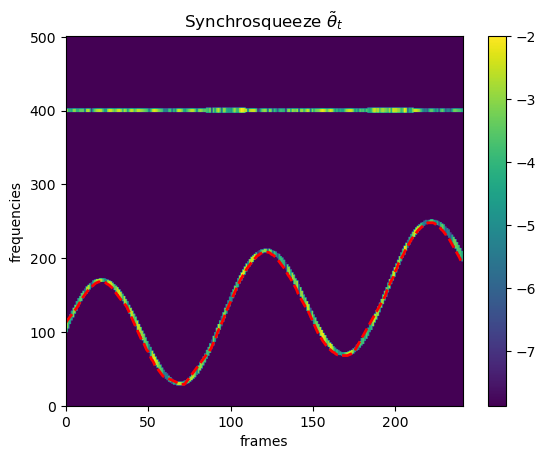

$\mathcal{R}_f$


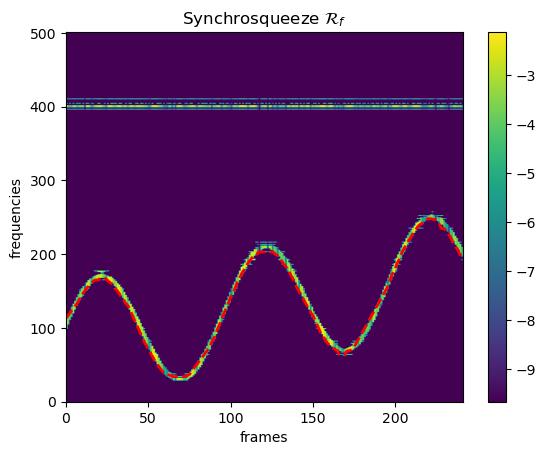

$\mathcal{R}_{tf}$


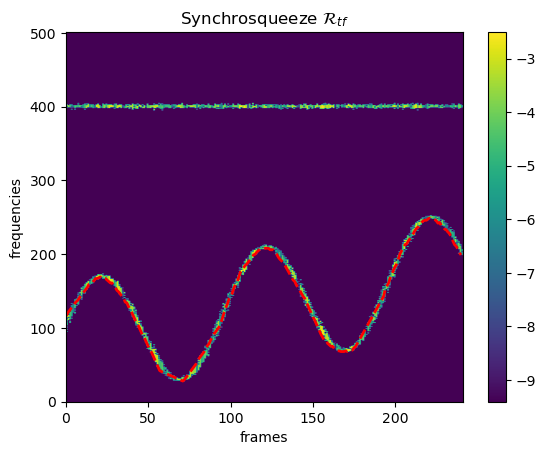

$\theta_f$


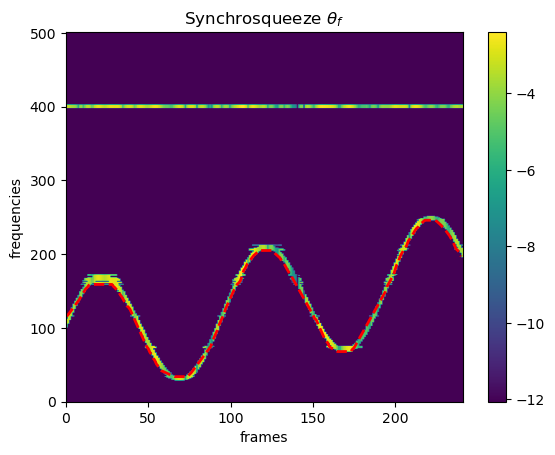

$\tilde{\theta}_f$


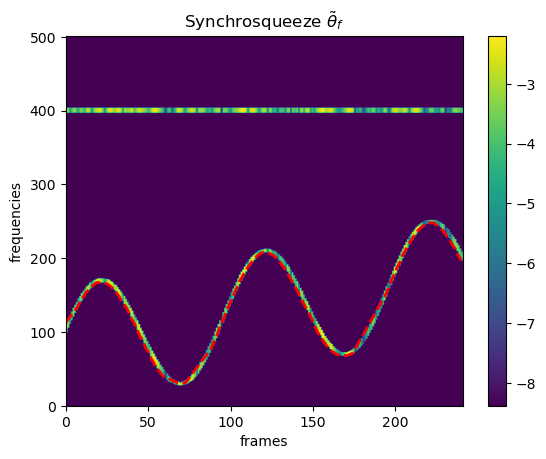

$\theta_{tf}$


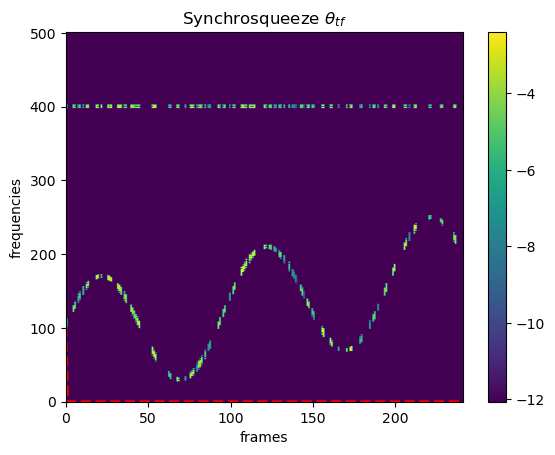

$\tilde{\theta}_{tf}$


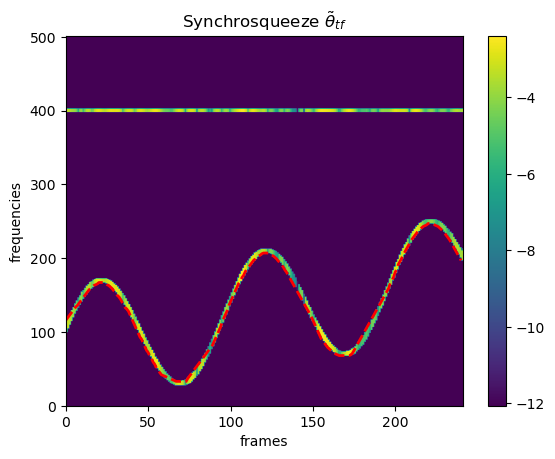

In [ ]:
with open("../tmp/1_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../tmp/1_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)

for key, out in f_hats.items(): 
    print(key)    
    plt.figure()
    plt.title(f'Synchrosqueeze {key}')
    ax = plt.subplot()
    im = ax.imshow(ss[key].log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu(), 'r--', linewidth=2)
    plt.show()
    

In [ ]:
f_sub = f[499:-500].unfold(0, 1, stride).flatten()

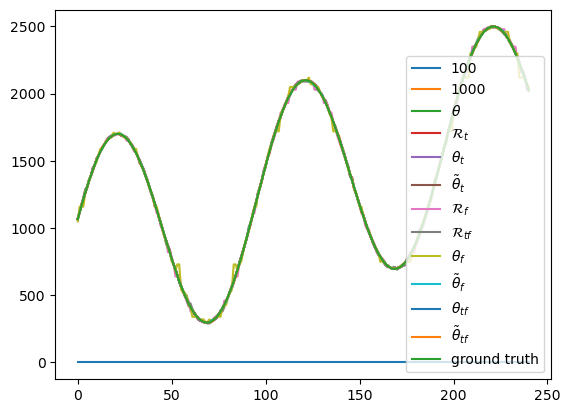

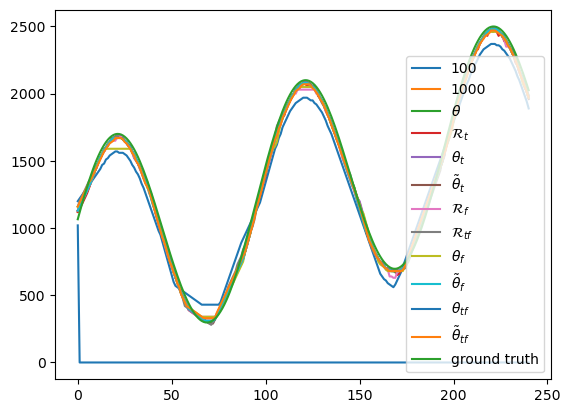

In [ ]:
with open("../tmp/1_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
for key, out in f_hats.items(): 
    f_hat = out * sr / support 
    plt.plot(f_hat.cpu(), label=key)
plt.plot(f_sub, label='ground truth')
plt.legend()

plt.figure()
with open("../tmp/1_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)
for key, out in f_hats.items(): 
    f_hat = out * sr / support 
    plt.plot(f_hat, label=key)
plt.plot(f_sub, label='ground truth')
plt.legend()

In [ ]:
with open("../tmp/1_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
with open("../tmp/1_mse.pkl", "rb") as file: mse = pickle.load(file)
mse = {}

for key, out in f_hats.items(): 
    f_hat = out * sr / support 
    mse[key] = torch.nn.functional.mse_loss(f_hat, f_sub).item()
    print(key, mse[key])

with open("../tmp/1_mse.pkl", "wb") as file: pickle.dump(mse, file, pickle.HIGHEST_PROTOCOL)

with open("../tmp/1_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)
with open("../tmp/1_mse2.pkl", "rb") as file: mse = pickle.load(file)
mse = {}

for key, out in f_hats.items(): 
    f_hat = out * sr / support 
    mse[key] = torch.nn.functional.mse_loss(f_hat, f_sub).item()
    print(key, mse[key])

with open("../tmp/1_mse2.pkl", "wb") as file: pickle.dump(mse, file, pickle.HIGHEST_PROTOCOL)


100 9.220876693725586
1000 88.9986801147461
$\theta$ 10.472975730895996
$\mathcal{R}_t$ 17.91143035888672
$\theta_t$ 65.38577270507812
$\tilde{\theta}_t$ 10.12750244140625
$\mathcal{R}_f$ 232.9564208984375
$\mathcal{R}_{tf}$ 95.04815673828125
$\theta_f$ 650.4409790039062
$\tilde{\theta}_f$ 9.226130485534668
$\theta_{tf}$ 2357725.25
$\tilde{\theta}_{tf}$ 9.124496459960938
100 12321.7685546875
1000 1598.416015625
$\theta$ 1573.9520263671875
$\mathcal{R}_t$ 1824.3221435546875
$\theta_t$ 1666.3609619140625
$\tilde{\theta}_t$ 1641.0810546875
$\mathcal{R}_f$ 2039.8277587890625
$\mathcal{R}_{tf}$ 1282.9149169921875
$\theta_f$ 2383.720947265625
$\tilde{\theta}_f$ 1669.415283203125
$\theta_{tf}$ 2353022.25
$\tilde{\theta}_{tf}$ 2224.0908203125


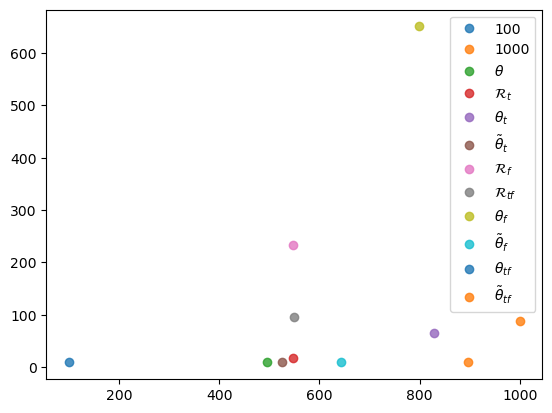

In [ ]:
with open("../tmp/1_mse.pkl", "rb") as file: mses = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, mse in mses.items(): plt.plot(wins[key][0], mse, 'o', alpha=.8, label=f'{key}')
plt.legend()
plt.show()

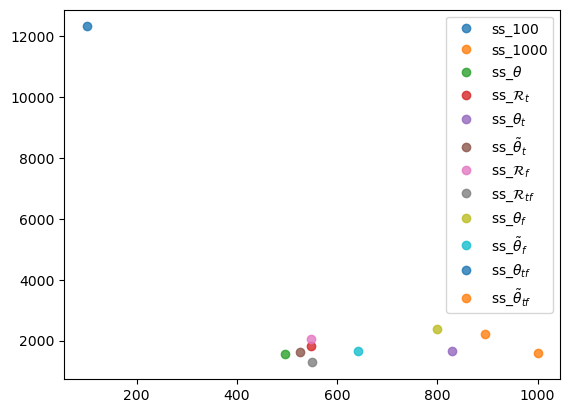

In [ ]:
with open("../tmp/1_mse2.pkl", "rb") as file: mses = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, mse in mses.items(): plt.plot(wins[key][0], mse, 'o', alpha=.8, label=f'ss_{key}')
plt.legend()
plt.show()

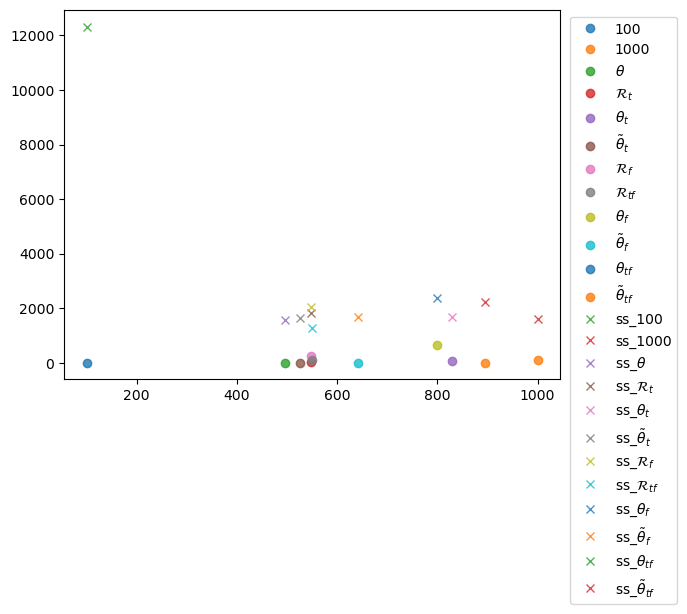

In [ ]:
with open("../tmp/1_mse.pkl", "rb") as file: mses = pickle.load(file)
with open("../tmp/1_mse2.pkl", "rb") as file: mses2 = pickle.load(file)
with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, mse in mses.items(): plt.plot(wins[key][0], mse, 'o', alpha=.8, label=key)
for key, mse in mses2.items(): plt.plot(wins[key][0], mse, 'x', alpha=.8, label=f'ss_{key}')
plt.legend(bbox_to_anchor=(1.25, 1))
plt.show()

In [ ]:
with open("../tmp/1_mse.pkl", "rb") as file: mses = pickle.load(file)
with open("../tmp/1_mse2.pkl", "rb") as file: mses2 = pickle.load(file)
#with open("../tmp/1_wins.pkl", "rb") as file: wins = pickle.load(file)

min_mse = 100; min_key = None
for key, mse in mses.items(): 
    if mse < min_mse:
        min_mse = mse
        min_key = key
print(min_mse, min_key)
    
min_mse = 100; min_key = None
for key, mse in mses2.items(): 
    if mse < min_mse:
        min_mse = mse
        min_key = key
print(min_mse, min_key)

9.124496459960938 $\tilde{\theta}_{tf}$
100 None


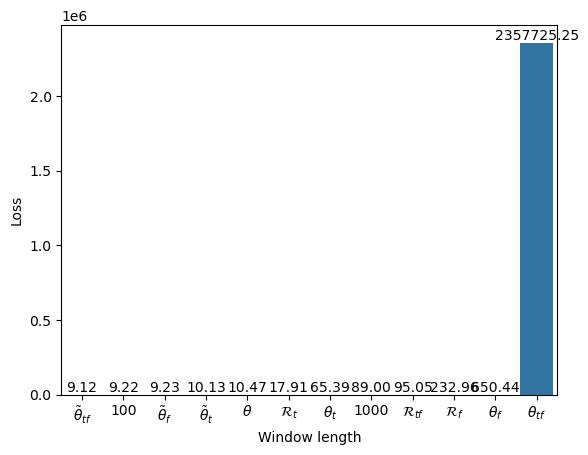

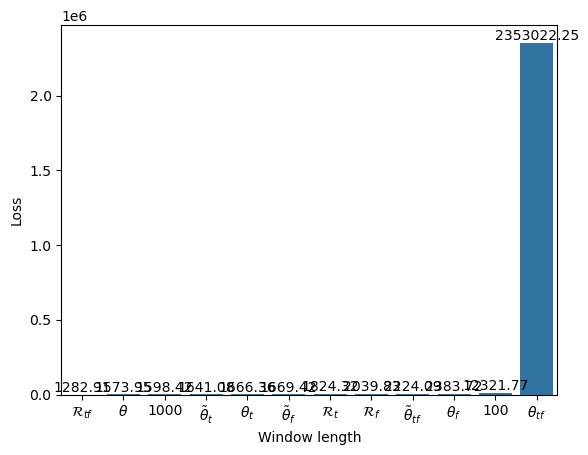

In [ ]:
keys = ['$\\theta$', 'random', 't2']
with open("../tmp/1_mse.pkl", "rb") as file: mses = pickle.load(file)
keys = list(mses.keys())
values = list(mses.values())

df = pd.DataFrame({"Window length":keys, "Loss":values})

df.sort_values(by="Loss", axis=0, inplace=True)
df.head()
ax = sns.barplot(y='Loss', data=df, x="Window length")#or hue='Method
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f'); 
    
plt.figure()
keys = ['$\\theta$', 'random', 't2']
with open("../tmp/1_mse2.pkl", "rb") as file: mses = pickle.load(file)
keys = list(mses.keys())
values = list(mses.values())

df = pd.DataFrame({"Window length":keys, "Loss":values})

df.sort_values(by="Loss", axis=0, inplace=True)
df.head()
ax = sns.barplot(y='Loss', data=df, x="Window length")#or hue='Method
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f'); 